In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.0.0


In [17]:
import torch_geometric
from torch_geometric.datasets import Planetoid

In [18]:
use_cuda_if_available = False

# Load the dataset

In [19]:
dataset = Planetoid(root="tutorial1",name= "Cora")

##### Dataset properties

Dataset: Cora

Description: Cora는 citation network에 대한 데이터세트다.

number of graph 는 1개에 불과하지만, features는 각각의 노드마다 1433이다. 여기서는 edge는 그냥 연결성만 의미하기 때문에 별도의 feature가 없음.

마지막으로 7개의 서로다른 features가 존재한다.

In [20]:
print(dataset)
print("number of graphs:\t\t",len(dataset))
print("number of classes:\t\t",dataset.num_classes)
print("number of node features:\t",dataset.num_node_features)
print("number of edge features:\t",dataset.num_edge_features)

Cora()
number of graphs:		 1
number of classes:		 7
number of node features:	 1433
number of edge features:	 0


##### Dataset shapes

In [21]:
print(dataset.data)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


/Users/dongjaekim/opt/anaconda3/envs/graph-neural-net/lib/python3.8/site-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


dataset.data를 하면 이 안에 들어있는 정보가 나온다. 여기서 각각의 edge_index는 예를들어 [0,633],[0,1862]로 쓰여져 있는데
이거는 각각 노드 0 번으로부터 노드 633, 1862로 선이 그어져 있음을 의미한다.

train_mask, validation_mask는 one-dimensional tensor로 이 녀석들이 각각 train 데이터인지 validation data 인지를 나타내고 있다.

x 도 있는데, x는 노드의 feature를 나타내고, 사이즈를 보면 [2708, 1433] 으로 되어있는데 2708은 전체 노드의 갯수이고 1433은 각각의 노드의 feature를 의미한다.

y 는 노드의 label을 의미한다. 모든 노드는 7개의 category로 구분되어 들어간다.

In [22]:
print("edge_index:\t\t",dataset.data.edge_index.shape)
print(dataset.data.edge_index)
print("\n")
print("train_mask:\t\t",dataset.data.train_mask.shape)
print(dataset.data.train_mask)
print("\n")
print("x:\t\t",dataset.data.x.shape)
print(dataset.data.x)
print("\n")
print("y:\t\t",dataset.data.y.shape)
print(dataset.data.y)

edge_index:		 torch.Size([2, 10556])
tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])


train_mask:		 torch.Size([2708])
tensor([ True,  True,  True,  ..., False, False, False])


x:		 torch.Size([2708, 1433])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


y:		 torch.Size([2708])
tensor([3, 4, 4,  ..., 3, 3, 3])


### Visualization

여기서는 networkx라는 tool을 사용했습니다.
근데 Cora 데이터셋이 너무 커서 유의미하게 보이진 않습니다.

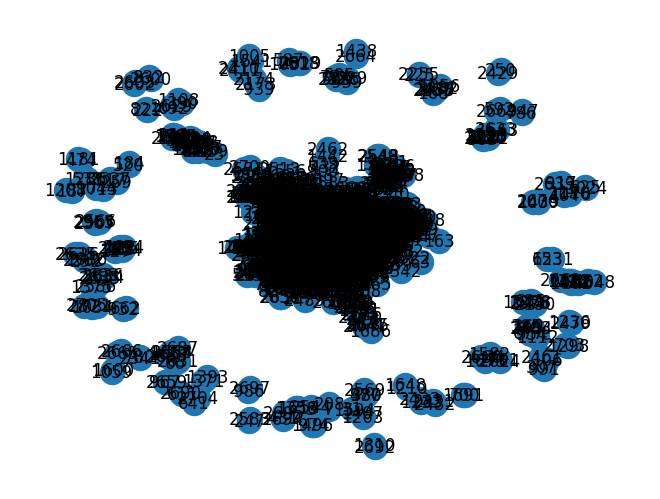

In [23]:
import networkx as nx
from torch_geometric.utils import to_networkx

data = dataset[0]
G = to_networkx(data, to_undirected=True)
nx.draw(G, with_labels=True)
# G = nx.Graph()

이 networkx는 단순하게 visualization 하는데만 쓰는게 아니고 실제로 우리가 직접 네트워크로 넣어줄 그래프를 만들어서 전환하는데도 쓴다.

예를 들어서 torch_geometric 은 networkx로부터 불러오는 함수를 갖고 있음.

In [29]:
from torch_geometric.utils.convert import from_networkx

networkx에서 예를 들어서 다음과 같이 노드를 추가하고 엣지를 추가하는 방식으로 네트워크를 구성했다고 해보자.

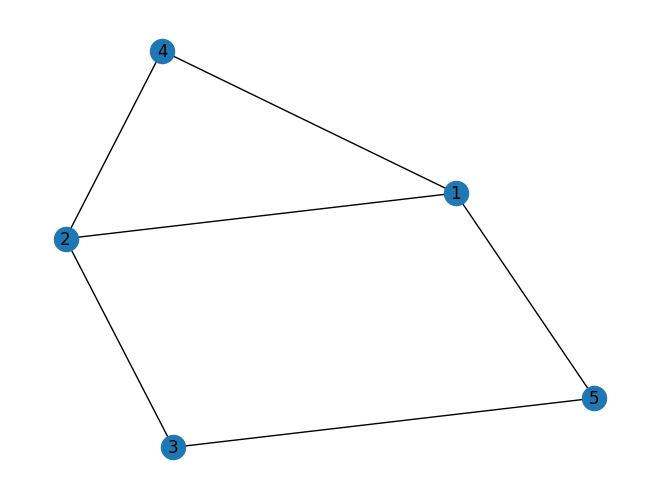

In [27]:
# Make the networkx graph
G = nx.Graph()
# Add some cars (just do 4 for now)
G.add_nodes_from([
      (1, {'y': 1, 'x': 0.5}),
      (2, {'y': 2, 'x': 0.2}),
      (3, {'y': 3, 'x': 0.3}),
      (4, {'y': 4, 'x': 0.1}),
      (5, {'y': 5, 'x': 0.2}),
])
# Add some edges
G.add_edges_from([
                  (1, 2), (1, 4), (1, 5),
                  (2, 3), (2, 4),
                  (3, 2), (3, 5),
                  (4, 1), (4, 2),
                  (5, 1), (5, 3)
])
nx.draw(G, with_labels=True)


그럼 아래와 같이 구성된다.

In [30]:
# Convert the graph into PyTorch geometric
pyg_graph = from_networkx(G)

print(pyg_graph)
# Data(edge_index=[2, 12], x=[5], y=[5])
print(pyg_graph.x)
# tensor([0.5000, 0.2000, 0.3000, 0.1000, 0.2000])
print(pyg_graph.y)
# tensor([1, 2, 3, 4, 5])
print(pyg_graph.edge_index)
# tensor([[0, 0, 0, 1, 1, 1, 2, 2, 3, 3, 4, 4],
#         [1, 3, 4, 0, 2, 3, 1, 4, 0, 1, 0, 2]])


Data(x=[5], edge_index=[2, 12], y=[5])
tensor([0.5000, 0.2000, 0.3000, 0.1000, 0.2000])
tensor([1, 2, 3, 4, 5])
tensor([[0, 0, 0, 1, 1, 1, 2, 2, 3, 3, 4, 4],
        [1, 3, 4, 0, 2, 3, 1, 4, 0, 1, 0, 2]])


ㅇㅋ 그럼 tutiorial에서 본것중에 가장 마지막에 본 graphSAGE에 대해서 보자. 이미 구현된 코드를 갖다가 쓸거다.

In [55]:
import os.path as osp

import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, GraphConv


In [59]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv = GraphConv(dataset.num_features,
                             dataset.num_classes, aggr='mean') # 1433개의 features로부터 7개의 class로 간다.
        # MLP도 없고 해서 아마 굉장히 간단해서 별로 잘 될거같진 않지만 ~

    def forward(self):
        x = self.conv(data.x, data.edge_index) #이렇게 두개를 넣어줘야 - 그래프에 대해서 인식할 수 있어서 이렇게 넣어준다.
        return F.log_softmax(x, dim=1) # 그렇게 각각의 노드가 7개의 값중에 어떤 클래스에 해당하는지에 대한 확률값으로 저장되게하기 위해서 softmax한다.


In [56]:
device = torch.device('cuda' if torch.cuda.is_available() and use_cuda_if_available else 'cpu')
model, data = Net().to(device), data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [57]:
device

device(type='cpu')

In [58]:
def train():
    model.train()
    optimizer.zero_grad()
    F.nll_loss(model()[data.train_mask], data.y[data.train_mask]).backward()
    optimizer.step()


def test():
    model.eval()
    logits, accs = model(), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

In [60]:
best_val_acc = test_acc = 0
for epoch in range(1,100):
    train()
    _, val_acc, tmp_test_acc = test()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
    log = 'Epoch: {:03d}, Val: {:.4f}, Test: {:.4f}'
    
    if epoch % 10 == 0:
        print(log.format(epoch, best_val_acc, test_acc))

Epoch: 010, Val: 0.7240, Test: 0.7110
Epoch: 020, Val: 0.7240, Test: 0.7110
Epoch: 030, Val: 0.7240, Test: 0.7110
Epoch: 040, Val: 0.7240, Test: 0.7110
Epoch: 050, Val: 0.7240, Test: 0.7110
Epoch: 060, Val: 0.7240, Test: 0.7110
Epoch: 070, Val: 0.7260, Test: 0.7130
Epoch: 080, Val: 0.7280, Test: 0.7130
Epoch: 090, Val: 0.7280, Test: 0.7130


In [61]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv = SAGEConv(dataset.num_features,
                             dataset.num_classes,
                             aggr="max") # max, mean, add ...)

    def forward(self):
        x = self.conv(data.x, data.edge_index)
        return F.log_softmax(x, dim=1)


In [62]:
best_val_acc = test_acc = 0
for epoch in range(1,100):
    train()
    _, val_acc, tmp_test_acc = test()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
    log = 'Epoch: {:03d}, Val: {:.4f}, Test: {:.4f}'

    if epoch % 10 == 0:
        print(log.format(epoch, best_val_acc, test_acc))

Epoch: 010, Val: 0.7240, Test: 0.7210
Epoch: 020, Val: 0.7240, Test: 0.7210
Epoch: 030, Val: 0.7240, Test: 0.7210
Epoch: 040, Val: 0.7240, Test: 0.7210
Epoch: 050, Val: 0.7240, Test: 0.7210
Epoch: 060, Val: 0.7240, Test: 0.7210
Epoch: 070, Val: 0.7240, Test: 0.7210
Epoch: 080, Val: 0.7240, Test: 0.7210
Epoch: 090, Val: 0.7240, Test: 0.7210
